# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Загрузим необходимые для работы библиотеки.

In [1]:
pip install ydata_profiling

     |████████████████████████████████| 357 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 394 kB 22.8 MB/s eta 0:00:01
     |████████████████████████████████| 296 kB 74.3 MB/s eta 0:00:01
     |████████████████████████████████| 102 kB 41.2 MB/s eta 0:00:01
     |████████████████████████████████| 513 kB 74.5 MB/s eta 0:00:01
     |████████████████████████████████| 686 kB 80.7 MB/s eta 0:00:01
     |████████████████████████████████| 4.5 MB 66.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 30.2 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 78.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 59.9 MB/s eta 0:00:01
     |████████████████████████████████| 16.8 MB 75.5 MB/s eta 0:00:01
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27085 sha256=e9322247978b0cc3c81cab7532e8ebe1d1472a8afc17a8f90ebb382722ec19b5
  Stored in directory: /home/jovyan/.cache/pip/wheels/1d/05/04/c6d7d3b66539d9e659ac6dfe8

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import time
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.dummy import DummyRegressor
from IPython.core.display import display, HTML

In [3]:
display(HTML("<style>.container { width:90% !important; }</style>"))

Загрузим датафрейм в переменную df.

In [4]:
df = pd.read_csv('/datasets/autos.csv')

Посмотрим ProfileReport по исходным данным.

In [5]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

ValueError: Only supported for TrueType fonts

<Figure size 432x288 with 0 Axes>

Запишем размер изначального датафрейма в переменную, чтобы позже выяснить процент удаленных данных.

In [6]:
size_before = df.shape

Посмотрим на гистограммы по данным отдельно.

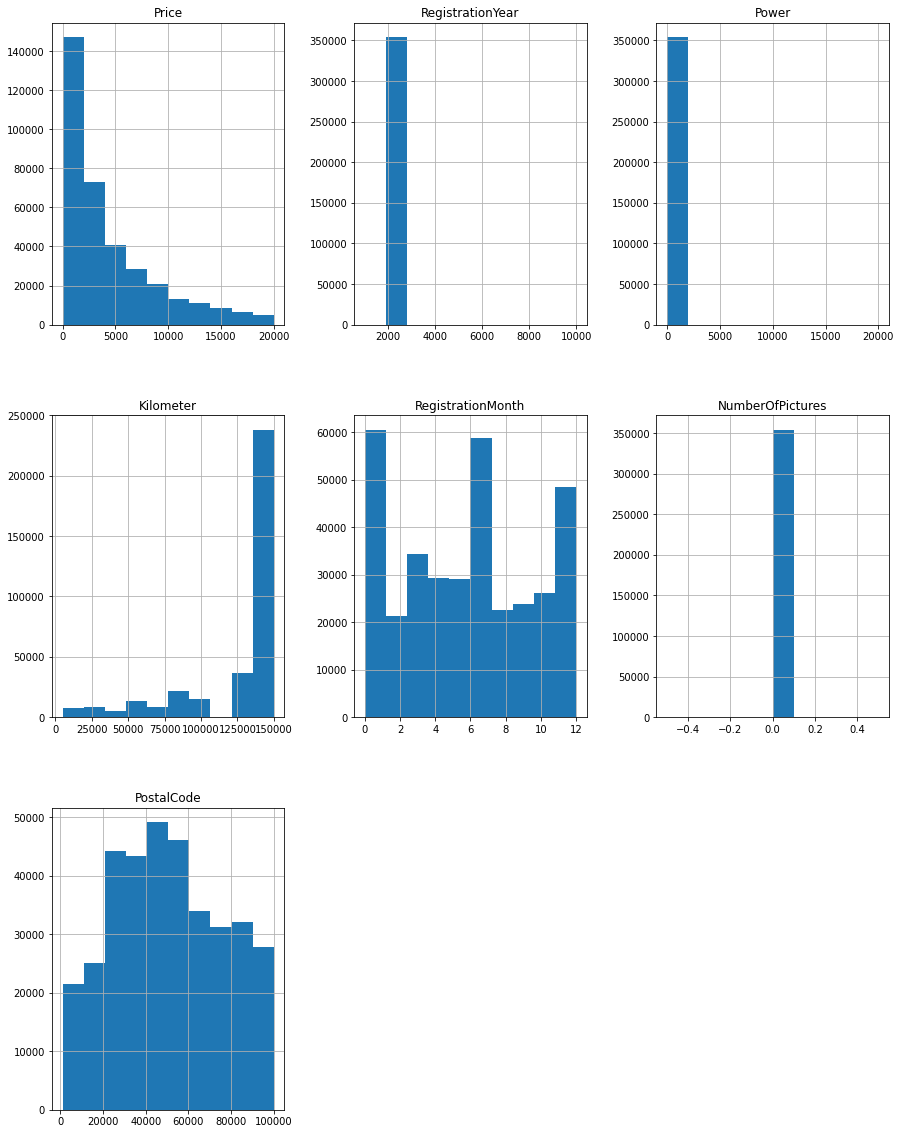

In [7]:
df.hist(figsize=(15, 20))

plt.show()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Посмотрим на уникальные значения столбца 'Kilometer'.

In [9]:
df.Kilometer.unique()

array([150000, 125000,  90000,  40000,  30000,  70000,   5000, 100000,
        60000,  20000,  80000,  50000,  10000])

Увидим, что данные в столбце посути являются категоральными.

Посмотрим на уникальные данные в столбце 'FuelType'.

In [10]:
df.FuelType.unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Обозначения Petrol и Gasoline дублируют друг друга.

Посмотрим на значения в столбце 'RegistrationYear'.

<AxesSubplot:>

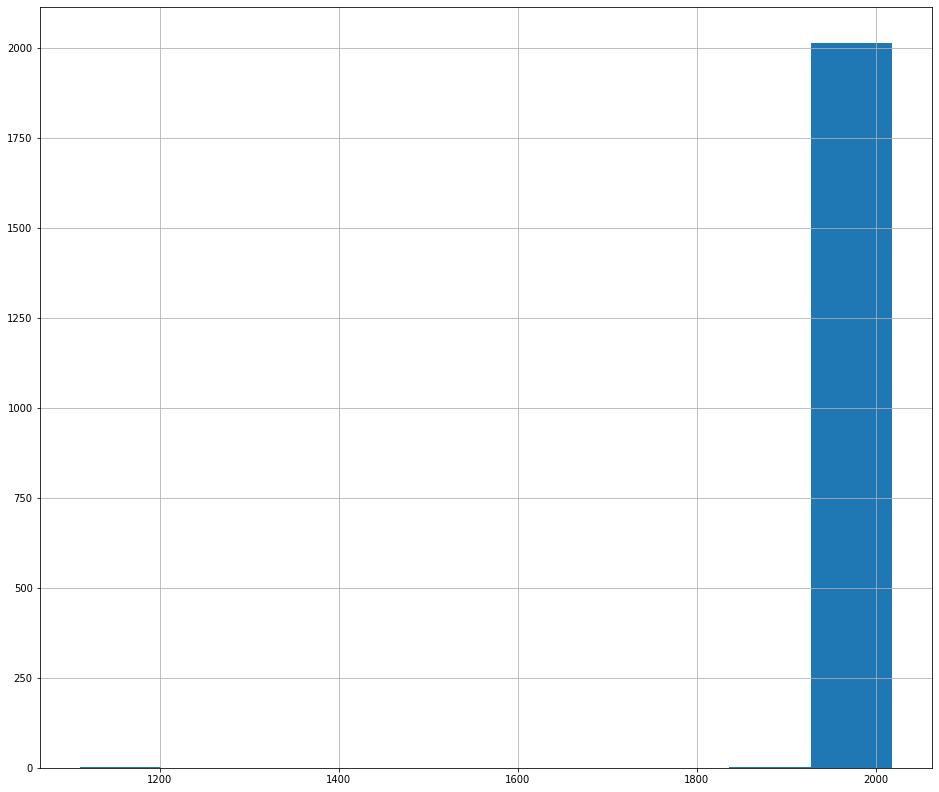

In [11]:
df.RegistrationYear[:2016].hist(figsize=(16,14))

In [12]:
df.RegistrationYear.unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

Данных до 1960 года очень мало. Можно их не учитывать. Так же можно увидеть много выбросов в этих данных. Необходимо удалить все значения больше 2016-го года.

Посмотрим значения столбца 'Power'.

<AxesSubplot:>

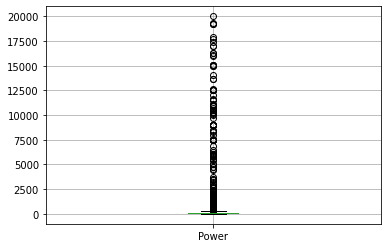

In [13]:
df.boxplot(column='Power')

In [14]:
df.Power.unique()

array([    0,   190,   163,    75,    69,   102,   109,    50,   125,
         101,   105,   140,   115,   131,    60,   136,   160,   231,
          90,   118,   193,    99,   113,   218,   122,   129,    70,
         306,    95,    61,   177,    80,   170,    55,   143,    64,
         286,   232,   150,   156,    82,   155,    54,   185,    87,
         180,    86,    84,   224,   235,   200,   178,   265,    77,
         110,   144,   120,   116,   184,   126,   204,    88,   194,
         305,   197,   179,   250,    45,   313,    41,   165,    98,
         130,   114,   211,    56,   201,   213,    58,   107,    83,
         174,   100,   220,    85,    73,   192,    68,    66,   299,
          74,    52,   147,    65,   310,    71,    97,   239,   203,
           5,   300,   103,   258,   320,    63,    81,   148,    44,
         145,   230,   280,   260,   104,   188,   333,   186,   117,
         141,    59,   132,   234,   158,    39,    92,    51,   135,
          53,   209,

В данных в столбце 'Power' присутствуют выбросы. Необходимо их удалить.

Посмотрим на столбцы с пропусками.

In [15]:
df[df['VehicleType'].isna() & df['FuelType'].isna() & df['Model'].isna()&df['Repaired'].isna()&df['Gearbox'].isna()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
306,2016-03-21 14:38:37,200,NaN,2009,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-03-21 00:00:00,0,6493,2016-03-24 02:47:34
522,2016-03-14 18:40:14,0,NaN,2000,NaN,0,NaN,150000,0,NaN,volvo,NaN,2016-03-14 00:00:00,0,25524,2016-03-14 18:40:14
538,2016-03-15 17:43:21,2600,NaN,2005,NaN,0,NaN,125000,0,NaN,chevrolet,NaN,2016-03-15 00:00:00,0,94315,2016-04-06 14:45:44
552,2016-03-21 10:52:52,50,NaN,1985,NaN,0,NaN,150000,11,NaN,trabant,NaN,2016-03-21 00:00:00,0,69120,2016-03-22 14:50:41
622,2016-03-16 16:55:09,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-16 00:00:00,0,44628,2016-03-20 16:44:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353727,2016-03-20 17:56:59,1,NaN,2000,NaN,0,NaN,150000,0,NaN,bmw,NaN,2016-03-20 00:00:00,0,42329,2016-04-07 00:46:36
354073,2016-03-19 14:53:26,1750,NaN,1995,NaN,0,NaN,100000,12,NaN,sonstige_autos,NaN,2016-03-19 00:00:00,0,6188,2016-04-01 01:47:17
354083,2016-03-30 07:54:17,0,NaN,2000,NaN,0,NaN,150000,0,NaN,sonstige_autos,NaN,2016-03-30 00:00:00,0,6686,2016-04-06 23:46:19
354162,2016-03-07 19:51:14,1500,NaN,1995,NaN,0,NaN,150000,0,NaN,volkswagen,NaN,2016-03-07 00:00:00,0,26789,2016-04-03 11:46:59


В данных есть неинформативные столбцы ('NumberOfPictures', 'PostalCode', 'DateCreated', 'LastSeen', 'RegistrationMonth', 'DateCrawled') и столбцы с отсутствующими данными, которые важны для исследования ('VehicleType', 'Model', 'FuelType','NotRepaired'). Первые можно просто удалить из датафрейма, а вторые заполнить значением 'unknown', так как восстановить значения не представляется возможным. Например, для некоторых моделей есть разные типы двигателей, коробок и т.д.

Посмотрим уникальные значения столбца 'Model'.

In [16]:
df.Model.sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

Среди данных есть модели обозначенные 'Other'. Нужно привести их к оному типу и обозначить 'unknown'.

Увидим, что в данных присутствуют:

- неинформативные признаки ('NumberOfPictures', 'PostalCode', 'DateCreated', 'LastSeen', 'RegistrationMonth', 'DateCrawled')
- пропуски в значений в данных ('VehicleType', 'Model', 'FuelType','NotRepaired')
- странные значения некоторых признаков ('RegistrationYear', 'Power')
- нулевые значение в столбце 'Price'
- неявные дубликаты в столбце 'FuelType'
- дубликаты признаков  
  
Нужно провести предобработку данных.

### Предобработка данных

1. Удалим столбцы с неинформативными признаками.

In [17]:
df = df.drop(['NumberOfPictures', 'PostalCode', 'DateCreated', 'LastSeen', 'RegistrationMonth', 'DateCrawled'], axis=1)

2. Заменим пропуски в столбцах 'VehicleType', 'Model', 'FuelType', 'NorRepaired', 'GearBox'. Значения 'other' в столбце 'Model' так де приравняем к 'unknown'.

In [18]:
df['VehicleType'] = df['VehicleType'].fillna('unknown')
df['Model'] = df['Model'].fillna('unknown')
df['FuelType'] = df['FuelType'].fillna('unknown')
df['Repaired'] = df['Repaired'].fillna('unknown')
df['Gearbox'] = df['Gearbox'].fillna('unknown')

df.loc[df['Model'] == 'other', 'Model'] = 'unknown'

3. Обработаем значения в столбцах 'RegistrationYear', 'Power'.  
   Год выпуска определим с 1960 по 2016.  
   Мощность ограничим по квантилям.

In [19]:
# RegistrationYear 
def RegYear(pow):
    if pow > 2016:
        return 2016
    elif pow < 1960:
        return 1960
    else:
        return pow
df["RegistrationYear"] = df["RegistrationYear"].apply(RegYear)


Заменим выбросы в столбце 'Power'.

В столбце 'Power' присутствует множество значений больше 10000. Возможно, это связано с тем, что неправильно указана точка для разделения разрядов. Предлагаю такие данные разделить на 100.

In [20]:
df.loc[(df.Power >= 10000), 'Power'] = df.Power / 100

Посмотрим на оставшиеся выбросы.

<AxesSubplot:>

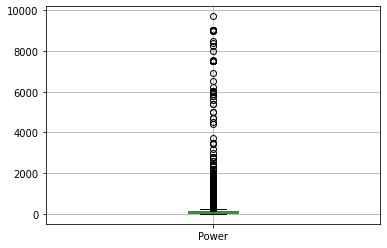

In [21]:
df.boxplot(column='Power')

До 10000 еще много выбросов осталось. Нормализуем данные по верхней границе нормальных даннных.

In [22]:
power_q25 = df['Power'].quantile(0.25)
power_q75 = df['Power'].quantile(0.75)
power_iqr = power_q75 - power_q25
power_right = power_q75 + power_iqr * 1.5
#высчитаем верхнюю границу нормализованных данных

df['Power'].clip(upper=power_right, inplace=True)
#заменим данные в таблице по верхней границе на высчитанную границу нормализованных данных

df.query('Power > @power_right')['Power'].sum()
#проверим, что данных больше ceiling_height_right в столбце не осталось

0.0

Снизу заменим данные до 40л.с. медианными значениями.

In [23]:
df.loc[(df.Power <40), 'Power'] = df.Power.median()

In [24]:
df.describe()

,Price,RegistrationYear,Power,Kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2003.050495,117.810075,128211.172535
std,4514.158514,7.279382,46.725299,37905.341530
min,0.000000,1960.000000,40.000000,5000.000000
25%,1050.000000,1999.000000,86.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,2016.000000,254.000000,150000.000000


4. Обработаем выбросы в столбце 'Price'

In [25]:
df.Price.value_counts()

0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

<AxesSubplot:>

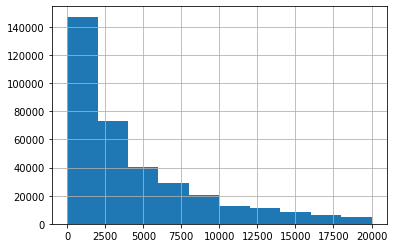

In [26]:
df.Price.hist()

Увидим, что в ценах есть нулевые значения. Так как строк с ценами ниже 50 евро составляют незначительный процент от всего датафрейма, то просто удалим их.

In [27]:
df = df.loc[df['Price'] > 50]

5. Обработаем неявные дубликаты в столбце 'FuelType'.

In [28]:
df.FuelType = df.FuelType.replace(['gasoline'],'petrol')

6. Посмотрим на количество дубликатов и удалим их.

In [29]:
df.duplicated().sum()

44657

In [30]:
#удалим дубликаты и проверим, что все впорядке
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

Проверим, что датафрейм готов к работе.

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296962 entries, 0 to 296961
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             296962 non-null  int64  
 1   VehicleType       296962 non-null  object 
 2   RegistrationYear  296962 non-null  int64  
 3   Gearbox           296962 non-null  object 
 4   Power             296962 non-null  float64
 5   Model             296962 non-null  object 
 6   Kilometer         296962 non-null  int64  
 7   FuelType          296962 non-null  object 
 8   Brand             296962 non-null  object 
 9   Repaired          296962 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 22.7+ MB


In [32]:
size_after = df.shape
100-size_after[0]/size_before[0]*100


16.199780454836628

### Вывод

При анализе данных было вывлены недостатки датафрейма, которые могли влиять на качество модели, а именно:
- неинформативные признаки ('NumberOfPictures', 'PostalCode', 'DateCreated', 'LastSeen', 'RegistrationMonth', 'DateCrawled')
- пропуски в значений в данных ('VehicleType', 'Model', 'FuelType','NotRepaired')
- странные значения некоторых признаков ('RegistrationYear', 'Power')
- нулевые значения в столбце 'Price'
- дубликаты признаков

В связи с этим понадобилась предобработка данных.  
В рамках предобработки данных были исключены неинформативные столбцы, обработаны пропуски в данных, исключены странные значения в столбцах, исключены нулевые значения в столбце 'Price' и дубликаты.  
После обработки данных было исключено 16% данных.

## Обучение моделей

В качестве моделей выберем 4 вида моделей:
- линейная регрессия
- LightGBM
- CatBoost

1. Закодируем категоральные признаки методом OHE

In [33]:
#закодируем признаки
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.head()

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
0,480,1993,105.0,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,2011,190.0,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163.0,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75.0,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69.0,90000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


2. Выделим целевой признак в отдельную переменную.

In [34]:
target_ohe = df_ohe['Price']
#запишем целевой признак в переменную target

features_ohe = df_ohe.drop('Price', axis=1)
#запишем остальные признаки в переменную features

3. Разделим на тестовую и обучающие выборки.

In [35]:
features_ohe_train, features_ohe_test, target_ohe_train, target_ohe_test = train_test_split(
    features_ohe, target_ohe, test_size=0.4, random_state=12345) 
#разобьем данные на обучающие и валидационную

In [36]:
print(features_ohe_train.shape)
print(features_ohe_test.shape)

(178177, 309)
(118785, 309)


### Модель LightGBM

Построим модель LightGBM со стандартными параметрами и посмотрим значение метрики RMSE.

In [37]:
%%time
model_lgb = lgb.LGBMRegressor(random_state=12345)
model_lgb.fit(features_ohe_train, target_ohe_train)
predictions_train_lgb = model_lgb.predict(features_ohe_train)
rmse_lgb = mean_squared_error(target_ohe_train, predictions_train_lgb)**0.5
rmse_lgb

CPU times: user 9.91 s, sys: 440 ms, total: 10.3 s
Wall time: 10.4 s


1766.4363025973903

Подберем гиперпараметры методом GridSearchCV.

In [38]:
param_grid_lgb = {'n_estimators': [100, 200, 500], 'num_leaves': [n for n in range(20, 100, 10)]}

lgb_gscv=GridSearchCV(estimator=model_lgb,
                          param_grid=param_grid_lgb,
                          scoring='neg_root_mean_squared_error',
                          cv=3,
                          verbose=3)

lgb_gscv.fit(features_ohe_train, target_ohe_train)
display(lgb_gscv.best_params_)
display(lgb_gscv.best_score_*-1)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END ................n_estimators=100, num_leaves=20; total time=   5.7s
[CV 2/3] END ................n_estimators=100, num_leaves=20; total time=   5.8s
[CV 3/3] END ................n_estimators=100, num_leaves=20; total time=   7.8s
[CV 1/3] END ................n_estimators=100, num_leaves=30; total time=   6.9s
[CV 2/3] END ................n_estimators=100, num_leaves=30; total time=   6.9s
[CV 3/3] END ................n_estimators=100, num_leaves=30; total time=   7.4s
[CV 1/3] END ................n_estimators=100, num_leaves=40; total time=   7.4s
[CV 2/3] END ................n_estimators=100, num_leaves=40; total time=   8.4s
[CV 3/3] END ................n_estimators=100, num_leaves=40; total time=   6.7s
[CV 1/3] END ................n_estimators=100, num_leaves=50; total time=  11.5s
[CV 2/3] END ................n_estimators=100, num_leaves=50; total time=  11.7s
[CV 3/3] END ................n_estimators=100, n

{'n_estimators': 500, 'num_leaves': 80}

1681.4185874575087

In [39]:
del lgb_gscv, param_grid_lgb

Добавим лучшие значения гиперпараметров в модель и выясним время обучение и результат модели.

In [40]:
start_time_train = time.time()

#построим модель с лучшими параметрами
model_lgb = lgb.LGBMRegressor(random_state=12345, 
                              num_leaves = 80,
                              n_estimators = 500)
model_lgb.fit(features_ohe_train, target_ohe_train)

end_time_train = time.time()
training_time_lgb = end_time_train - start_time_train

# Время обучения модели LightGBM
print("Время обучения LightGBM: %s секунд" % training_time_lgb)

# Время предсказания модели LightGBM на трейне
start_lgb_train = time.time()
pred_lgb_train = model_lgb.predict(features_ohe_train)
end_lgb_train = time.time()
prediction_time_lgb_train = end_lgb_train - start_lgb_train
print("Время предсказания LightGBM на трейне: %s секунд" % prediction_time_lgb_train)

# Оценка качества модели LightGBM на трейне
rmse_lgb_train = mean_squared_error(target_ohe_train, pred_lgb_train, squared=False)
print("RMSE LightGBM на трейне: %.2f" % rmse_lgb_train)

Время обучения LightGBM: 40.61595034599304 секунд
Время предсказания LightGBM на трейне: 12.188930034637451 секунд
RMSE LightGBM на трейне: 1475.48


In [41]:
del start_time_train, end_time_train, training_time_lgb, start_lgb_train, pred_lgb_train, end_lgb_train, prediction_time_lgb_train, rmse_lgb_train

### Модель Линейной регрессии


Масштабируем признаки.

In [42]:
numeric = ['Power', 'Kilometer']
#запишем наименования численных столбцов в переменную numeric

features_ohe_train_lr = features_ohe_train
features_ohe_test_lr = features_ohe_test

scaler = StandardScaler()
#создадим переменную для стандартизатора

scaler.fit(features_ohe_train[numeric])
#передадим пример датафрейма стандартизатору

pd.options.mode.chained_assignment = None
#отключим стандартную ошибку

features_ohe_train_lr[numeric] = scaler.transform(features_ohe_train[numeric])
features_ohe_test_lr[numeric] = scaler.transform(features_ohe_test[numeric])
#масштабируем данные во всем датафрейме

Построим модель, посмотрим на время обучение и метрику RMSE.

In [43]:
start_time_train = time.time()

#построим модель с лучшими параметрами
model_lr = LinearRegression()
model_lr.fit(features_ohe_train_lr, target_ohe_train)

end_time_train = time.time()
training_time_lr = end_time_train - start_time_train

# Время обучения модели LinearRegression
print("Время обучения LinearRegression: %s секунд" % training_time_lr)

# Время предсказания модели LinearRegression на трейне
start_lr_train = time.time()
pred_lr_train = model_lr.predict(features_ohe_train)
end_lr_train = time.time()
prediction_time_lr_train = end_lr_train - start_lr_train
print("Время предсказания LinearRegression на трейне: %s секунд" % prediction_time_lr_train)

# Оценка качества модели LinearRegression на трейне
rmse_lr_train = mean_squared_error(target_ohe_train, pred_lr_train, squared=False)
print("RMSE LinearRegression на трейне: %.2f" % rmse_lr_train)

Время обучения LinearRegression: 17.243700742721558 секунд
Время предсказания LinearRegression на трейне: 0.3958711624145508 секунд
RMSE LinearRegression на трейне: 2740.55


In [44]:
del start_time_train, end_time_train, training_time_lr, start_lr_train, pred_lr_train, end_lr_train, prediction_time_lr_train, rmse_lr_train

### Модель CatBoost


Построим модель CatBoost со стандартными параметрами и посмотрим значение метрики RMSE.

In [45]:
%%time
model_cbr = CatBoostRegressor(loss_function='RMSE',
                              logging_level='Silent')
model_cbr.fit(features_ohe_train, target_ohe_train)
predictions_train_cbr = model_cbr.predict(features_ohe_train)
rmse_cbr = mean_squared_error(target_ohe_train, predictions_train_cbr)**0.5
rmse_cbr

CPU times: user 25.6 s, sys: 181 ms, total: 25.7 s
Wall time: 26.9 s


1648.6946887584477

In [46]:
del predictions_train_cbr, rmse_cbr

Подберем гиперпараметры методом GridSearchCV.

In [47]:
param_grid_cbr = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}

cbr_gscv=GridSearchCV(estimator=model_cbr,
                      param_grid=param_grid_cbr,
                      scoring='neg_root_mean_squared_error',
                      cv=3,
                      verbose=1)

cbr_gscv.fit(features_ohe_train, target_ohe_train)
display(cbr_gscv.best_params_)
display(cbr_gscv.best_score_*-1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


{'depth': 10, 'learning_rate': 0.1}

1683.7071433100907

In [48]:
del param_grid_cbr, cbr_gscv

Добавим лучшие значения гиперпараметров в модель и выясним время обучение и результат модели.

In [ ]:
start_time_train = time.time()

#построим модель с лучшими параметрами
model_cbr = CatBoostRegressor(random_state=12345, 
                              depth = 10,
                              learning_rate = 0.1,
                              logging_level = 'Silent')
model_cbr.fit(features_ohe_train, target_ohe_train)

end_time_train = time.time()
training_time_cbr_train = end_time_train - start_time_train

# Время обучения модели CatBoost
print("Время обучения CatBoost: %s секунд" % training_time_cbr_train)

# Время предсказания модели CatBoost на трейне
start_cbr_train = time.time()
pred_cbr_train = model_cbr.predict(features_ohe_train)
end_cbr_train = time.time()
prediction_time_cbr_train = end_cbr_train - start_cbr_train
print("Время предсказания CatBoost на трейне: %s секунд" % prediction_time_cbr_train)

# Оценка качества модели CatBoost на трейне
rmse_cbr_train = mean_squared_error(target_ohe_train, pred_cbr_train, squared=False)
print("RMSE CatBoost на трейне: %.2f" % rmse_cbr_train)

In [ ]:
del start_time_train, end_time_train, training_time_cbr_train, start_cbr_train, pred_cbr_train, end_cbr_train, prediction_time_cbr_train, rmse_cbr_train

## Анализ моделей

В предыдущей главе были рассмотрены модели LightGBM, CatBoost и LinearRegression.  
Данные по моделям были получены следующие:  
<br>
1. LightGBM.   
Время обучения LightGBM: 566.6495299339294 секунд  
Время предсказания LightGBM на трейне: 11.43785309791565 секунд  
RMSE LightGBM на трейне: 1475.48  
<br>

2. LinearRegression.  
Время обучения LinearRegression: 21.655750513076782 секунд  
Время предсказания LinearRegression на трейне: 0.39702773094177246 секунд  
RMSE LinearRegression на трейне: 2740.55  
<br>  

3. CatBoost.  
Время обучения CatBoost: 57.93861389160156 секунд
Время предсказания CatBoost на трейне: 0.9522836208343506 секунд
RMSE CatBoost на трейне: 1486.27
<br>

Исходя из условий задачи (RMSE дожен быть ниже 2500) сразу можно откинуть модель LinearRegression так как не удовлетворят требованию по качеству.
Несмотря на то, что остальные кандидаты оказались близки друг к другу по качеству, лучшие характеристики показала модель CatBoost, так как оказалась значительно быстрее. Выберем ее для предсказания на тесте.

In [ ]:
# Время предсказания модели CatBoost на тесте
start_cbr_test = time.time()
pred_cbr_test = model_cbr.predict(features_ohe_test)
end_cbr_test = time.time()
prediction_time_cbr_test = end_cbr_test - start_cbr_test
print("Время предсказания CatBoost на тесте: %s секунд" % prediction_time_cbr_test)

# Оценка качества модели CatBoost на тесте
rmse_cbr_test = mean_squared_error(target_ohe_test, pred_cbr_test, squared=False)
print("RMSE CatBoost на тесте: %.2f" % rmse_cbr_test)

## Вывод


В данном проекте были проанализрованы различные модели предсказания стоимости автомобиля.  
Основными критериями выбора модели были заявлены:
<br>
- качество предсказания;
- время обучения модели;
- время предсказания модели.
  

  
Исходя из полученных данных самая быстрая и качественная модель это модель LightGBM. LinearRegression оказалась быстрой, но качество сильно ниже чем требуется по условию задачи. LightGBM показала хорошую метрику, но по времени сильно уступает Catboost.
Рекомендую использовать модель CatBoost для опеределения рыночной стоимости автомобилей для привлечения новых клиентов.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей